In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os
import shutil
import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [ ]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database
License(s): copyright-authors
100% 776M/778M [00:04<00:00, 146MB/s]
100% 778M/778M [00:05<00:00, 160MB/s]


In [ ]:
!unzip '/content/covid19-radiography-database.zip'

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

In [ ]:
PATH_TO_METADATA = "/content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx"
df = pd.read_excel(PATH_TO_METADATA)
df.head()

,FILE NAME,FORMAT,SIZE,URL
0,NORMAL-1,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
1,NORMAL-2,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
2,NORMAL-3,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
3,NORMAL-4,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...
4,NORMAL-5,PNG,256*256,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [ ]:
!ls /tmp

dap_multiplexer.148cca951510.root.log.INFO.20240709-045911.110	 pyright-266-S2kQ8zQZZI9W
dap_multiplexer.INFO						 pyright-266-TCZ75Dsd3p1C
debugger_1cfz9xk3lr						 python-languageserver-cancellation
initgoogle_syslog_dir.0						 tmpmeqikn4x
language_service.148cca951510.root.log.INFO.20240709-045936.259  tmpxrfq8pcq
language_service.INFO


In [ ]:
!mkdir /tmp/Xray_train_data

In [ ]:
!cp -R "/content/COVID-19_Radiography_Dataset/COVID/images" "/tmp/Xray_train_data/"

In [ ]:
!mv "/tmp/Xray_train_data/images" "/tmp/Xray_train_data/COVID"

In [ ]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [ ]:
!mkdir "/tmp/Xray_train_data/NORMAL"

In [ ]:
cnt = 0
for (i, row) in df.iterrows():
    if (cnt < 3616):
        filename = row["FILE NAME"].lower().capitalize() + "." + row["FORMAT"].lower()
        image_path = os.path.join("/content/COVID-19_Radiography_Dataset/Normal/images", filename)
        image_copy_path = os.path.join("/tmp/Xray_train_data/NORMAL", filename)
        shutil.copy2(image_path, image_copy_path)
        cnt += 1

print(cnt)

3616


In [ ]:
!ls "/tmp/Xray_train_data"

COVID  NORMAL


In [ ]:
!ls -1 "/tmp/Xray_train_data/COVID"| wc -l

3616


In [ ]:
!ls -1 "/tmp/Xray_train_data/NORMAL"| wc -l

3616


In [ ]:
train_data_dir= "/tmp/Xray_train_data"

In [ ]:
IMAGE_SIZE = (224, 224)
IMAGE_SHAPE = IMAGE_SIZE + (3,)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_height, img_width= IMAGE_SIZE
batch_size=16
train_datagen = ImageDataGenerator(validation_split=0.3)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation')

Found 5064 images belonging to 2 classes.
Found 2168 images belonging to 2 classes.


In [ ]:
data_augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomRotation(
        factor=(-0.2, 0.3),
        fill_mode='reflect',
        interpolation='bilinear',
        seed=None
    ),
    tf.keras.layers.experimental.preprocessing.Rescaling(
        scale=1/.255,
        offset=0.0
    ),
])

In [ ]:
VGG16_model=tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=IMAGE_SHAPE),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dropout(.2, input_shape=(32,)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
VGG16_model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 4)

trainer=VGG16_model.fit(train_generator,validation_data=validation_generator,epochs=30, callbacks = [es])

Epoch 1/30
317/317 [==============================] - 30s 80ms/step - loss: 72.0578 - accuracy: 0.6159 - val_loss: 50.1352 - val_accuracy: 0.5466
Epoch 2/30
317/317 [==============================] - 21s 67ms/step - loss: 13.7683 - accuracy: 0.6860 - val_loss: 5.8304 - val_accuracy: 0.7477
Epoch 3/30
317/317 [==============================] - 21s 65ms/step - loss: 9.3634 - accuracy: 0.6823 - val_loss: 6.9081 - val_accuracy: 0.6697
Epoch 4/30
317/317 [==============================] - 21s 67ms/step - loss: 4.5314 - accuracy: 0.7127 - val_loss: 2.6225 - val_accuracy: 0.7578
Epoch 5/30
317/317 [==============================] - 20s 62ms/step - loss: 2.7409 - accuracy: 0.7222 - val_loss: 2.2925 - val_accuracy: 0.7113
Epoch 6/30
317/317 [==============================] - 21s 67ms/step - loss: 2.0427 - accuracy: 0.7387 - val_loss: 1.9990 - val_accuracy: 0.7145
Epoch 7/30
317/317 [==============================] - 20s 64ms/step - loss: 1.5869 - accuracy: 0.7346 - val_loss: 1.4291 - val_accura

In [ ]:
VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, None, None, None   0         
                             )                                   
                                                                 
 conv2d (Conv2D)             (None, None, None, 8)     224       
                                                                 
 max_pooling2d (MaxPooling2  (None, None, None, 8)     0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 16)    1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, None, None, 16)    0         
 g2D)                                                            
                                                      

Text(0.5, 1.0, 'Training-Validation Accuracy')

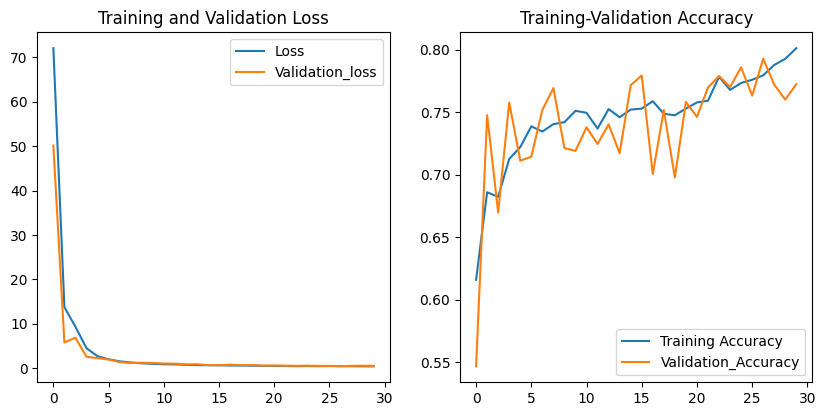

In [ ]:
loss=pd.DataFrame(VGG16_model.history.history)

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(loss["loss"],label="Loss")
plt.plot(loss["val_loss"],label="Validation_loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.subplot(2,2,2)
plt.plot(loss['accuracy'],label="Training Accuracy")
plt.plot(loss['val_accuracy'],label="Validation_Accuracy")
plt.legend()
plt.title("Training-Validation Accuracy")

In [ ]:
probabilities = VGG16_model.predict_generator(generator=validation_generator)
print("Probability Predictor: \n",probabilities)

<ipython-input-32-4a8b077a102d>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  probabilities = VGG16_model.predict_generator(generator=validation_generator)


Probability Predictor: 
 [[0.12161712]
 [0.22986539]
 [0.82597893]
 ...
 [0.01624351]
 [0.98981655]
 [0.99967515]]


In [ ]:
y_true = validation_generator.classes
y_pred = probabilities > 0.5
print("Probability Predictor with a condition: \n", y_pred)

Probability Predictor with a condition: 
 [[False]
 [False]
 [ True]
 ...
 [False]
 [ True]
 [ True]]


In [ ]:
class_report = classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys()))
print("Classification Report:\n", class_report)

Classification Report:
               precision    recall  f1-score   support

       COVID       0.50      0.46      0.48      1084
      NORMAL       0.50      0.54      0.52      1084

    accuracy                           0.50      2168
   macro avg       0.50      0.50      0.50      2168
weighted avg       0.50      0.50      0.50      2168



Confusion Matrix:
        COVID  NORMAL
COVID     498     586
NORMAL    503     581


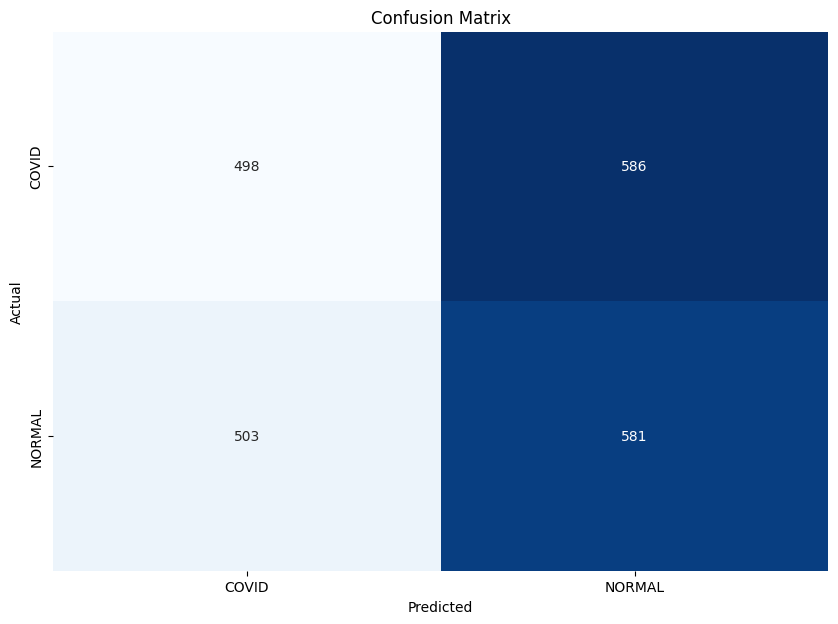

In [ ]:
cf_matrix = confusion_matrix(y_true, y_pred)
class_names = list(validation_generator.class_indices.keys())
cf_matrix_df = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
print("Confusion Matrix:")
print(cf_matrix_df)
plt.figure(figsize=(10, 7))
sns.heatmap(cf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
VGG16_model.save('VGG16-Covid.hs')